In [15]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("../roll_data/*-bird-message.csv")

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

seasons = [11, 12, 13, 14]
df = df[df['season'].isin(seasons)]
len(df)

22097

In [16]:
dfc = df.copy()
# dfc["ballpark_fortification"] = dfc["ballpark_fortification"] - 0.5
dfc = dfc[dfc["roll"] < 0.025]


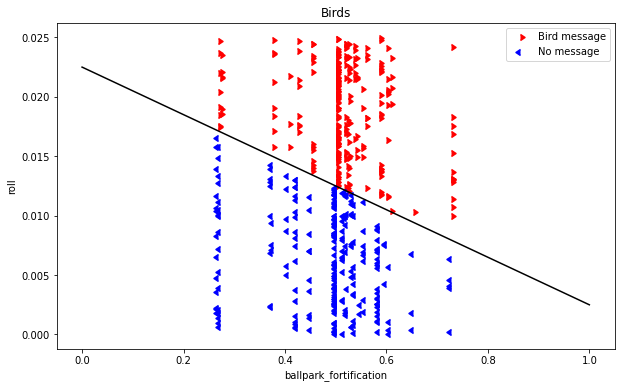

In [17]:
x_val = "ballpark_fortification"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="Bird message",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="No message",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title("Birds")

# might also be coefficient 0.0195 or similar, still getting one outlier
ax.plot((0, 1), (0.0225, 0.0025), "k")
ax.legend()

In [18]:
X = dfc[
    [
        "roll",
        "passed",
        "ballpark_fortification",
    ]
].copy()
y = X["passed"]
X = X.drop("passed", axis=1)

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000000).fit(
    X2, y
)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))

[[254   0]
 [  0 251]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       254
        True       1.00      1.00      1.00       251

    accuracy                           1.00       505
   macro avg       1.00      1.00      1.00       505
weighted avg       1.00      1.00      1.00       505



In [20]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.02224226]


[(1.0, 'roll'), (0.019590222898572957, 'ballpark_fortification')]